# Rainy Day Bay Area Bike EDA

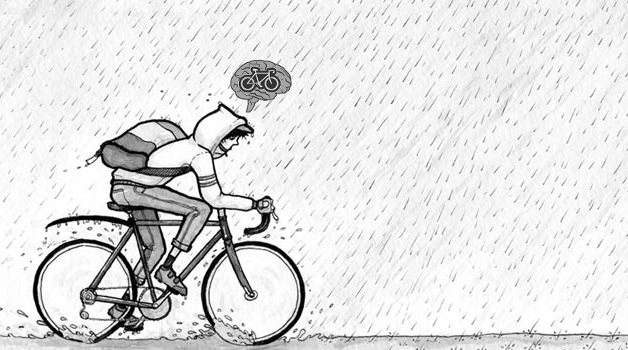

[image source](https://humancyclist.wordpress.com/2016/03/13/what-i-think-about-when-im-cycling/)

This EDA will allow me to practice working with both SQL and Python code. This should help me take a step or two out of my R comfort zone. Further down I get into how rain can affect Bike trips in the California Bay Area

In [ ]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import shutil
import matplotlib.pyplot as plt
import matplotlib.dates as mdt
import datetime as dtm

## Connecting to the SQLite Database

Lets connect to and take a look at the tables within the database.

We will save a copy of the database in the working directory to give us writing privileges 

In [ ]:
shutil.copyfile(r"../input/sf-bay-area-bike-share/database.sqlite", r"./database.sqlite" )
connection = sql.connect(r"./database.sqlite")
tables = pd.read_sql_query("select name from sqlite_master where type = 'table'", connection)
tables.style.set_caption("Database Table Names")

Lets delineate the variables in each table. 

In [ ]:
station_info = pd.read_sql_query("pragma table_info(station)", connection)
status_info = pd.read_sql_query("pragma table_info(status)", connection)
trip_info = pd.read_sql_query("pragma table_info(trip)", connection)
weather_info = pd.read_sql_query("pragma table_info(weather)", connection)

In [ ]:
station_info.style.set_caption("Station Variables")

In [ ]:
status_info.style.set_caption("Status Variables")

In [ ]:
trip_info.style.set_caption("Trip Variables")
#zip code data is entered by the user and is unreliable. Will need to be removed. 

In [ ]:
weather_info.style.set_caption("Weather Variables")
#zip code data is reliable

We need to add a table to this database linking Zip_Codes to their associated cities

In [ ]:
connection.execute("CREATE TABLE city_zip (zip_code integer, city text)")

In [ ]:
connection.execute("""INSERT INTO city_zip (zip_code, city) 
                                  VALUES (94107, 'San Francisco'), (94063, 'Redwood City'), 
                                         (94301, 'Palo Alto'), (94041, 'Mountain View'), 
                                         (95113, 'San Jose')""")

city_zip = pd.read_sql_query("SELECT * FROM city_zip", connection)
city_zip

Now that we have a good overview of the variables from the tables, lets take a look at the  number of records in each table.

In [ ]:
sizes = [{"station" : connection.execute("select count() FROM station").fetchone()[0]},
         {"status" : connection.execute("select count() from status").fetchone()[0]},
         {"trip" : connection.execute("select count() from trip").fetchone()[0]},
         {"weather" : connection.execute("select count() from weather").fetchone()[0]}]
print(sizes)

### Descriptive Statistics

Lets summarize some of the numeric data from the tables using the SQLite aggregate functions avg(), max(), and min(). We will remove all records with empty values from the tables. 

Before we create a summary for the weather table, we need to update the precipitation data. There is a 'T' assigned to dates where there is still precipitation, but only a trace amount (less than 0.01), so, for the purposes of this study, any amount less than 0.01 will be considered to be 0.

In [ ]:
#writing sqlite queries will take up a lot of space for the tables with many variables. 
#The Following function will make things more concise. 
def Desc_Query(table, *arg):
    average_chunk = ""
    min_chunk = ""
    max_chunk = ""
    for x in arg:
        average_chunk = average_chunk + ", " + "avg(" + x + ") as " + x 
        min_chunk = min_chunk + ", " + "min(" + x + ") as " + x
        max_chunk = max_chunk + ", " + "max(" + x + ") as " + x
    average_chunk = average_chunk[2:]
    min_chunk = min_chunk[2:]
    max_chunk = max_chunk[2:]
    
    query = ("select 'average', " + average_chunk + " from " + table + 
             " where " + " <> '' AND ".join(arg) + " <> '' union " + 
             
             "select 'min', " + min_chunk + " from " + table + 
             " where " + " <> '' AND ".join(arg) + " <> '' union " + 
             
             "select 'max', " + max_chunk + " from " + table + 
             " where " + " <> '' AND ".join(arg) + " <> ''")
    
    return(query)


station_summary = pd.read_sql_query(Desc_Query("station", 
                                               "dock_count"), connection)
status_summary = pd.read_sql_query(Desc_Query("status", 
                                              "bikes_available", 
                                              "docks_available"), connection)
trip_summary = pd.read_sql_query(Desc_Query("trip", 
                                            "duration"), connection) 

#T character removal prior to summarizing
connection.execute(""" UPDATE weather 
                            SET precipitation_inches = 0 
                            WHERE precipitation_inches = 'T'""")

weather_summary = pd.read_sql_query(Desc_Query("weather", 
                                               "mean_temperature_f", 
                                               "mean_dew_point_f", 
                                               "mean_humidity",
                                              "mean_sea_level_pressure_inches", 
                                               "mean_visibility_miles",
                                              "mean_wind_speed_mph", 
                                               "precipitation_inches", 
                                               "cloud_cover"), connection)

In [ ]:
station_summary.rename(columns = {"'average'" : "Stat"}).style.set_caption("Station Variable Summary")

In [ ]:
status_summary.rename(columns = {"'average'" : "Stat"}).style.set_caption("Status Variable Summary")

In [ ]:
trip_summary.rename(columns = {"'average'" : "Stat"}).style.set_caption("Trip Variable Summary")
#duration is the time of the trip in seconds

In [ ]:
weather_summary.rename(columns = {"'average'" : "Stat"}).style.set_caption("Weather Variable Summary")
#cloud_cover between 0:8. 0 - clear skies

## Exploratory Data Analysis

I predict that there is a proportional relationship between the duration of a trip and the precipitation on the date when the cyclist began their trip.

### Wet Cities

Lets look at the total precipitation across all of the cities. We will filter the data to focus on the year 2014, as this is the only table wherein each day of the year has data. 

In [ ]:
#because dates are stored in text format, we will use the function substr() and length() to extract the year from each date.

Wet_Cities_Query =  """ SELECT  substr(date, length(date) - 3) as 'Year', 
                                weather.zip_code, city, 
                                sum(precipitation_inches) as 'Precipitation'  
                        FROM weather 
                        LEFT JOIN city_zip 
                                ON weather.zip_code = city_zip.zip_code 
                        WHERE substr(date, length(date) - 3) = '2014'
                        GROUP BY substr(date, length(date) - 3), weather.zip_code""" 

Wet_Cities = pd.read_sql_query(Wet_Cities_Query, connection)
Wet_Cities.style.set_caption("Precipitation by City Over Time")

In [ ]:
Wet_Cities

In [ ]:
plt.style.use('fivethirtyeight')

plt.bar(Wet_Cities.city, Wet_Cities.Precipitation)

plt.title("Total Precipitation by city in 2014")
plt.ylabel("Total Precipitation in 2014 (in)")
plt.xticks(rotation = 'vertical')

### Rainy Trips

Looks like certain cities got more rain than others. 
Lets see if we can compare precipitation to trip duration.

Like above, we will filter for the year 2014


In [ ]:
#methods for extracting months and days from dates formatted as "mm/dd/yyyy" through SQLite appear convoluted under initial examination.
#Date Transformations will need to be done via Python scripting, the pandas to_datetime method should work. 
Wet_Trips_Query = """ SELECT  trip.start_station_id, 
                              trip.id as 'trip_id',
                              trip.start_date, 
                              trip.duration, station.city, 
                              city_zip.zip_code
                      FROM trip
                      LEFT JOIN station
                          ON trip.start_station_id = station.id 
                      LEFT JOIN city_zip
                          ON station.city = city_zip.city"""



Wet_Trips = pd.read_sql_query(Wet_Trips_Query, connection)
Wet_Trips[['date', 'time']] = Wet_Trips['start_date'].str.split(' ', expand = True)
Wet_Trips.drop(columns = ['start_date'], inplace = True)

Rain = pd.read_sql_query("""SELECT date, precipitation_inches 
                            FROM weather""", connection) 

In [ ]:
#filtering trip data by 2014
Wet_Trips['date'] = pd.to_datetime(Wet_Trips['date'], format = '%m/%d/%Y')
Wet_Trips['year'] = pd.DatetimeIndex(Wet_Trips['date']).year
Wet_Trips['month'] = pd.DatetimeIndex(Wet_Trips['date']).month

Wet_Trips_2014 = Wet_Trips[Wet_Trips['year'] == 2014]

#filtering Rain data by 2014
Rain['date'] = pd.to_datetime(Rain['date'], format = '%m/%d/%Y')
Rain['year'] = pd.DatetimeIndex(Rain['date']).year
Rain['month'] = pd.DatetimeIndex(Rain['date']).month

Rain_2014 = Rain[Rain['year'] == 2014]

In [ ]:
Wet_Trips_2014_month = Wet_Trips_2014.groupby(['month']).duration.median()

Rain_2014_month = Rain_2014.groupby(['month']).precipitation_inches.sum()

The following code is based on the dual y axis tutorial from the [Matplotlib website](https://matplotlib.org/gallery/api/two_scales.html)

In [ ]:
ax = plt.subplot()

plt.style.use('fivethirtyeight')

ax.plot(Rain_2014.month.unique(), Wet_Trips_2014_month, color = 'tab:red')
ax.set_xlabel('Month of the Year')
ax.set_ylabel('Median Trip Duration (s)', color = 'tab:red')
ax.tick_params(axis = 'y', labelcolor = 'tab:red')


ax2 = ax.twinx()

ax2.set_ylabel('Total Monthly Precipitation (in)', color = 'tab:blue')
ax2.bar(Rain_2014.month.unique(), Rain_2014_month, color = 'tab:blue', alpha = 0.5)
ax2.tick_params(axis = 'y', labelcolor = 'tab:blue')

plt.title('Precipitation vs. Trip Duration by Month')